In [1]:
# This a toy-example demonstrates the creation of a Bell state and then applying
# a classical loop to keep mixing the state of the qubit until
# the prepared qubit is in the |0> state.
# The program uses a toy layer to define the quantum operations.
import qstack

program = None

In [2]:
%%qstack
@instruction-set: toy

allocate q1:
  mix q1
  allocate q2:
    entangle q1 q2
  measure
measure


[Kernel(targets=(QubitId(value='q1'),), instructions=(QuantumInstruction(name='mix', targets=[QubitId(value='q1')], parameters={}), Kernel(targets=(QubitId(value='q2'),), instructions=(QuantumInstruction(name='entangle', targets=[QubitId(value='q1'), QubitId(value='q2')], parameters={}),), callback=None)), callback=None)]

In [3]:
# Set up a local quantum machine to execute the program.
# Each machine in qstack is created to target a specific stack or instruction set.
# This ensures that the machine can correctly interpret and execute the program's instructions.
from qstack.machine import local_machine_for, create_callbacks

machine = local_machine_for(program.instruction_set)


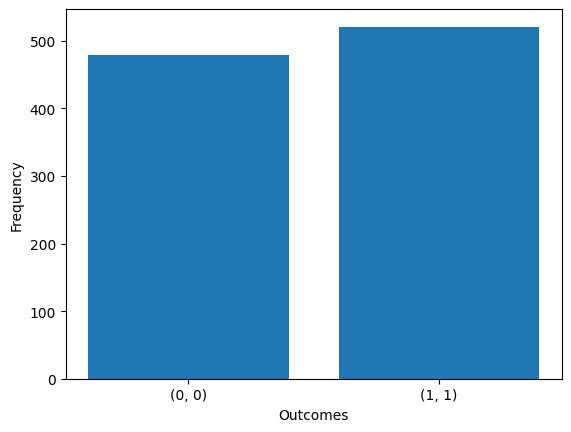

In [4]:
# Evaluate the program, it should give an even distribution betweek 
# (,0,0) and (1,1) when measuring the two qubits.

machine.eval(program).plot_histogram()


In [5]:
%%qstack
# Now incorporate a classical callback called repeat_until_zero...
# This callback will keep running the kernel until the outcome is "0".
# Since we're just consuming one outcome, the final result will be 0 followed by a list of 1s,
# a 1 for each time the loop was executed.
@instruction-set: toy

allocate q1:
  mix q1
  allocate q2:
    entangle q1 q2
  measure
measure
?? repeat_until_zero


[Kernel(targets=(QubitId(value='q1'),), instructions=(QuantumInstruction(name='mix', targets=[QubitId(value='q1')], parameters={}), Kernel(targets=(QubitId(value='q2'),), instructions=(QuantumInstruction(name='entangle', targets=[QubitId(value='q1'), QubitId(value='q2')], parameters={}),), callback=None)), callback=ClassicInstruction(name='repeat_until_zero', parameters={}))]

In [6]:
## The actual classical implementation of the callback:
from qstack.instruction_sets.toy import Mix, Entangle

# Define a classical callback for state preparation.
def repeat_until_zero(context):
    m = context.consume() 

    if m == 1:
        return qstack.Kernel(
            targets=["q1", "q2"], 
            instructions=[Mix("q1"), Entangle("q1", "q2")], 
            callback=qstack.ClassicInstruction("repeat_until_zero", parameters={}))
    else:
        return None



In [7]:
# We need a new machine for this program that can
# invoke the classical callback

callbacks = create_callbacks(repeat_until_zero)
machine = local_machine_for(program.instruction_set, callbacks)


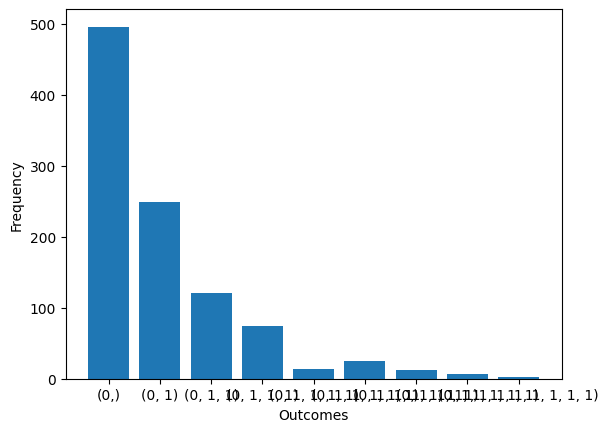

In [8]:
# The new histogram returns a distribution of bitstrings that start with 0
# followed by 1, the longer sequences appear much less, should be in exponential decay.

machine.eval(program).plot_histogram()


In [9]:
# Let's  turn on the logs
# and see the actual evaluation of the program.
# You'll notice that the number of calls to mix depends on the outcome as expected.
import logging

logger = logging.getLogger("qstack")

handler = logging.StreamHandler()
formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.DEBUG)

In [10]:
machine.single_shot(program)

2025-05-26 18:28:39,473 - DEBUG - restart: 2
2025-05-26 18:28:39,479 - DEBUG - eval: mix [1]
2025-05-26 18:28:39,482 - DEBUG - eval: entangle [0, 1]
2025-05-26 18:28:39,485 - DEBUG - outcome: 0
2025-05-26 18:28:39,487 - DEBUG - outcome: 0


(0,)

In [11]:
machine.single_shot(program)

2025-05-26 18:28:39,509 - DEBUG - restart: 2
2025-05-26 18:28:39,515 - DEBUG - eval: mix [1]
2025-05-26 18:28:39,517 - DEBUG - eval: entangle [0, 1]
2025-05-26 18:28:39,519 - DEBUG - outcome: 1
2025-05-26 18:28:39,520 - DEBUG - outcome: 1
2025-05-26 18:28:39,521 - DEBUG - eval: mix [1]
2025-05-26 18:28:39,523 - DEBUG - eval: entangle [0, 1]
2025-05-26 18:28:39,525 - DEBUG - outcome: 1
2025-05-26 18:28:39,528 - DEBUG - outcome: 1
2025-05-26 18:28:39,529 - DEBUG - eval: mix [1]
2025-05-26 18:28:39,530 - DEBUG - eval: entangle [0, 1]
2025-05-26 18:28:39,531 - DEBUG - outcome: 0
2025-05-26 18:28:39,532 - DEBUG - outcome: 0


(0, 1, 1)

In [26]:
machine.single_shot(program)

2025-05-26 18:28:58,477 - DEBUG - restart: 2
2025-05-26 18:28:58,480 - DEBUG - eval: mix [1]
2025-05-26 18:28:58,482 - DEBUG - eval: entangle [0, 1]
2025-05-26 18:28:58,484 - DEBUG - outcome: 1
2025-05-26 18:28:58,486 - DEBUG - outcome: 1
2025-05-26 18:28:58,487 - DEBUG - eval: mix [1]
2025-05-26 18:28:58,489 - DEBUG - eval: entangle [0, 1]
2025-05-26 18:28:58,490 - DEBUG - outcome: 1
2025-05-26 18:28:58,493 - DEBUG - outcome: 1
2025-05-26 18:28:58,495 - DEBUG - eval: mix [1]
2025-05-26 18:28:58,497 - DEBUG - eval: entangle [0, 1]
2025-05-26 18:28:58,501 - DEBUG - outcome: 1
2025-05-26 18:28:58,504 - DEBUG - outcome: 1
2025-05-26 18:28:58,515 - DEBUG - eval: mix [1]
2025-05-26 18:28:58,519 - DEBUG - eval: entangle [0, 1]
2025-05-26 18:28:58,521 - DEBUG - outcome: 1
2025-05-26 18:28:58,523 - DEBUG - outcome: 1
2025-05-26 18:28:58,525 - DEBUG - eval: mix [1]
2025-05-26 18:28:58,528 - DEBUG - eval: entangle [0, 1]
2025-05-26 18:28:58,530 - DEBUG - outcome: 1
2025-05-26 18:28:58,532 - DEBU

(0, 1, 1, 1, 1, 1)

In [27]:
# Compile the toy program to the minimal Clifford instruction set.
# This step translates the toy instructions (like 'mix' and 'entangle')
# into a form that can be executed by a Clifford-based backend.
# Note: The classical callback (repeat_until_zero) may generate new kernels at runtime.
# When compiling, the compiler does not directly transform these dynamically generated kernels.
# Instead, it wraps the classical callback into a function that, when invoked, first evaluates
# the kernel and then just-in-time (JIT) compiles it before execution.
from qstack.compilers.toy2cliffords import ToyCompiler

compiler = ToyCompiler()
compiled, compiled_callbacks = compiler.compile(program, callbacks)

# Print the compiled program to see the transformed representation.
print(compiled)


2025-05-26 18:29:03,344 - WARNING - Instruction skew has no handler.


@instruction-set: cliffords-min

allocate q1:
  h q1
  allocate q2:
    cx q1 q2
  measure
measure
?? _toy2cliffords_:repeat_until_zero


In [32]:
# Evaluate the compiled program using the minimal Clifford instruction set.
# The logs will show that the quantum instructions evaluated are not those returned by the original callback,
# but the ones corresponding to those after compilation.
# The logs will not show that the kernel is compiled JIT, but you can observe the effect by the instructions executed.
machine = local_machine_for(compiled.instruction_set, compiled_callbacks)

machine.single_shot(compiled)

2025-05-26 18:29:09,238 - DEBUG - Found gate x: [[0, 1], [1, 0]]
2025-05-26 18:29:09,242 - DEBUG - Found gate y: [[0, (-0-1j)], [1j, 0]]
2025-05-26 18:29:09,244 - DEBUG - Found gate h: [[0.7071, 0.7071], [0.7071, -0.7071]]
2025-05-26 18:29:09,246 - DEBUG - Found gate cz: [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, -1]]
2025-05-26 18:29:09,249 - DEBUG - Found gate z: [[1, 0], [0, -1]]
2025-05-26 18:29:09,251 - DEBUG - Found gate cx: [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]]
2025-05-26 18:29:09,255 - DEBUG - restart: 2
2025-05-26 18:29:09,259 - DEBUG - eval: h [1]
2025-05-26 18:29:09,261 - DEBUG - eval: cx [0, 1]
2025-05-26 18:29:09,263 - DEBUG - outcome: 1
2025-05-26 18:29:09,264 - DEBUG - outcome: 1
2025-05-26 18:29:09,266 - DEBUG - eval: h [1]
2025-05-26 18:29:09,268 - DEBUG - eval: cx [0, 1]
2025-05-26 18:29:09,269 - DEBUG - outcome: 1
2025-05-26 18:29:09,270 - DEBUG - outcome: 1
2025-05-26 18:29:09,272 - DEBUG - eval: h [1]
2025-05-26 18:29:09,273 - DEBUG - e

(0, 1, 1)